In [99]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
])
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

batch_size = 16

train_set = torchvision.datasets.CIFAR10(root='./data',train=True, download=False, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data',train=False, download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [100]:
class VGG_gradCAM(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradFeatureMap = dict()
        self.feats = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True)
            ),
            nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False),
                nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True)
            ),
            nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False),
                nn.Conv2d(64, 128, 3, 1, 1),
                nn.ReLU(True),
                nn.Conv2d(128, 128, 3, 1, 1),
                nn.ReLU(True)
            ),
        ])
        self.linear = nn.Sequential(
            nn.Linear(128*8*8, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        for feat in self.feats:
            x = feat(x)
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out
    
    def en_gradCam(self):
        def front_hook(module, grad_input, grad_output):
            self.gradFeatureMap[module] = grad_output
        def back_hook(module, grad_input, grad_output): 
            # print(self.gradFeatureMap[module].shape,grad_output[0].mean(dim=(2, 3)).unsqueeze(-1).unsqueeze(-1).shape)
            self.gradFeatureMap[module] = self.gradFeatureMap[module] * grad_output[0].mean(dim=(2, 3)).unsqueeze(-1).unsqueeze(-1)
        for l in self.feats:
            l.register_forward_hook(front_hook)
            l.register_full_backward_hook(back_hook)

    def showGradCAM(self, criterion, out, label):
        loss = criterion(out, label)
        loss.backward()
        if(self.gradFeatureMap == None):
            print("en_gradCam() function not declared.")
            return None
        
        out = nn.ReLU(True)(torch.einsum("b c w h -> b w h", list(self.gradFeatureMap.values())[0]))
        for i in list(self.gradFeatureMap.values())[1:]:
            out = out + nn.ReLU(True)(torch.einsum("b c w h -> b w h", torch.nn.functional.interpolate(i, size=(32, 32), mode = 'bilinear', align_corners=False)))

        return out

In [101]:
model = VGG_gradCAM()
model.en_gradCam()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

out= model(torch.randn(4, 3, 32, 32))
loss = criterion(out, torch.tensor([1, 2, 3, 4]))

model.showGradCAM(criterion, out, torch.tensor([1, 2, 3, 4])).shape

torch.Size([4, 32, 32])

In [102]:
for i in list(model.gradFeatureMap.values()):
    print(i.shape)

torch.Size([4, 16, 32, 32])
torch.Size([4, 64, 16, 16])
torch.Size([4, 128, 8, 8])


In [103]:
model = VGG_gradCAM()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # 0.001

### PRETRAINED MODEL LOAD

In [104]:
model.load_state_dict(torch.load('model_0.06458202814012766_.pt'))

<All keys matched successfully>

### TRAIN

In [105]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=20, gamma=0.5) 

epochs = 100
for ep in range(epochs):
    progressbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}", unit="batch")
    losses = 0
    for i, (data, label) in enumerate(progressbar):
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = criterion(out, label)
        losses += loss.item()
        loss.backward()
        optimizer.step()
    
    print(losses / (len(train_loader) * batch_size))

    # Validation phase
    progressbar = tqdm(test_loader, desc=f"Epoch {ep+1}/{epochs}", unit="batch")
    losses = 0
    correct = 0

    with torch.no_grad():
        for i, (data, label) in enumerate(progressbar):
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = criterion(out, label)
            losses += loss.item()
            _, predicted = torch.max(out, 1)
            
            # Count correct predictions
            correct += (predicted == label).sum().item()

    print(losses / (len(test_loader) * batch_size), "correct: ", correct, "/", (len(test_loader) * batch_size))

    # Step the scheduler at the end of the epoch
    scheduler.step()

Epoch 1/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.29batch/s]


0.056679769248962404


Epoch 1/100: 100%|██████████| 625/625 [00:02<00:00, 276.55batch/s]


0.0805930400699377 correct:  5852 / 10000


Epoch 2/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.77batch/s]


0.05898988904684782


Epoch 2/100: 100%|██████████| 625/625 [00:02<00:00, 280.07batch/s]


0.09695555438995361 correct:  5143 / 10000


Epoch 3/100: 100%|██████████| 3125/3125 [00:34<00:00, 89.37batch/s]


0.0605028258445859


Epoch 3/100: 100%|██████████| 625/625 [00:02<00:00, 248.92batch/s]


0.09915733483433724 correct:  4981 / 10000


Epoch 4/100: 100%|██████████| 3125/3125 [00:34<00:00, 90.43batch/s]


0.060499129519164564


Epoch 4/100: 100%|██████████| 625/625 [00:02<00:00, 248.78batch/s]


0.08514186127185822 correct:  5447 / 10000


Epoch 5/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.66batch/s]


0.061429593819975856


Epoch 5/100: 100%|██████████| 625/625 [00:02<00:00, 278.67batch/s]


0.08775821463763714 correct:  5652 / 10000


Epoch 6/100: 100%|██████████| 3125/3125 [00:34<00:00, 91.53batch/s]


0.06150685579717159


Epoch 6/100: 100%|██████████| 625/625 [00:02<00:00, 257.49batch/s]


0.10081476982831955 correct:  4894 / 10000


Epoch 7/100: 100%|██████████| 3125/3125 [00:34<00:00, 90.09batch/s]


0.06159653078258038


Epoch 7/100: 100%|██████████| 625/625 [00:02<00:00, 280.95batch/s]


0.0898558300614357 correct:  5325 / 10000


Epoch 8/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.97batch/s]


0.06193601959466934


Epoch 8/100: 100%|██████████| 625/625 [00:02<00:00, 269.74batch/s]


0.08917393405139447 correct:  5483 / 10000


Epoch 9/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.44batch/s]


0.061607406195104124


Epoch 9/100: 100%|██████████| 625/625 [00:02<00:00, 261.30batch/s]


0.0817646147429943 correct:  5614 / 10000


Epoch 10/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.53batch/s]


0.062207078438401224


Epoch 10/100: 100%|██████████| 625/625 [00:02<00:00, 272.63batch/s]


0.0853529142320156 correct:  5400 / 10000


Epoch 11/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.63batch/s]


0.062279290946125984


Epoch 11/100: 100%|██████████| 625/625 [00:02<00:00, 271.96batch/s]


0.10005730756521225 correct:  4843 / 10000


Epoch 12/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.09batch/s]


0.061720576547980306


Epoch 12/100: 100%|██████████| 625/625 [00:02<00:00, 261.99batch/s]


0.09282626493573189 correct:  5305 / 10000


Epoch 13/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.07batch/s]


0.06204391095638275


Epoch 13/100: 100%|██████████| 625/625 [00:02<00:00, 266.39batch/s]


0.1090177441895008 correct:  4959 / 10000


Epoch 14/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.25batch/s]


0.06181318513512611


Epoch 14/100: 100%|██████████| 625/625 [00:02<00:00, 281.20batch/s]


0.10602132912278175 correct:  4762 / 10000


Epoch 15/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.00batch/s]


0.06264394555807114


Epoch 15/100: 100%|██████████| 625/625 [00:02<00:00, 272.60batch/s]


0.09694904761910439 correct:  5246 / 10000


Epoch 16/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.60batch/s]


0.062045572202801706


Epoch 16/100: 100%|██████████| 625/625 [00:02<00:00, 295.31batch/s]


0.09227147162556648 correct:  5173 / 10000


Epoch 17/100: 100%|██████████| 3125/3125 [00:35<00:00, 89.01batch/s]


0.06284733882546426


Epoch 17/100: 100%|██████████| 625/625 [00:02<00:00, 265.45batch/s]


0.1010983639061451 correct:  4980 / 10000


Epoch 18/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.74batch/s]


0.062048010763525965


Epoch 18/100: 100%|██████████| 625/625 [00:02<00:00, 275.67batch/s]


0.14468739333748817 correct:  4086 / 10000


Epoch 19/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.29batch/s]


0.061867402749955655


Epoch 19/100: 100%|██████████| 625/625 [00:02<00:00, 283.94batch/s]


0.0864935197532177 correct:  5550 / 10000


Epoch 20/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.48batch/s]


0.061947736427485946


Epoch 20/100: 100%|██████████| 625/625 [00:02<00:00, 263.13batch/s]


0.1024164374411106 correct:  4904 / 10000


Epoch 21/100: 100%|██████████| 3125/3125 [00:34<00:00, 90.98batch/s]


0.05566971649006009


Epoch 21/100: 100%|██████████| 625/625 [00:02<00:00, 271.43batch/s]


0.10127209865450859 correct:  5035 / 10000


Epoch 22/100: 100%|██████████| 3125/3125 [00:35<00:00, 89.24batch/s]


0.054068743984103204


Epoch 22/100: 100%|██████████| 625/625 [00:02<00:00, 267.86batch/s]


0.08772922187745572 correct:  5591 / 10000


Epoch 23/100: 100%|██████████| 3125/3125 [00:34<00:00, 91.13batch/s]


0.0530464552038908


Epoch 23/100: 100%|██████████| 625/625 [00:02<00:00, 251.76batch/s]


0.0852467237174511 correct:  5771 / 10000


Epoch 24/100: 100%|██████████| 3125/3125 [00:34<00:00, 90.26batch/s]


0.05256650882601738


Epoch 24/100: 100%|██████████| 625/625 [00:02<00:00, 258.82batch/s]


0.08780105171203613 correct:  5703 / 10000


Epoch 25/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.26batch/s]


0.05189643735200167


Epoch 25/100: 100%|██████████| 625/625 [00:02<00:00, 268.87batch/s]


0.08749925854802132 correct:  5611 / 10000


Epoch 26/100: 100%|██████████| 3125/3125 [00:35<00:00, 89.20batch/s]


0.05195802449226379


Epoch 26/100: 100%|██████████| 625/625 [00:02<00:00, 277.06batch/s]


0.08304124991297722 correct:  5724 / 10000


Epoch 27/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.18batch/s]


0.05186131337761879


Epoch 27/100: 100%|██████████| 625/625 [00:02<00:00, 254.80batch/s]


0.08502292837202549 correct:  5686 / 10000


Epoch 28/100: 100%|██████████| 3125/3125 [00:36<00:00, 85.18batch/s]


0.05155986875548959


Epoch 28/100: 100%|██████████| 625/625 [00:02<00:00, 275.93batch/s]


0.09032878801226615 correct:  5664 / 10000


Epoch 29/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.19batch/s]


0.05112914512634277


Epoch 29/100: 100%|██████████| 625/625 [00:02<00:00, 271.59batch/s]


0.09373125136196614 correct:  5294 / 10000


Epoch 30/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.41batch/s]


0.05037654710054398


Epoch 30/100: 100%|██████████| 625/625 [00:02<00:00, 268.02batch/s]


0.08373249134719372 correct:  5848 / 10000


Epoch 31/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.42batch/s]


0.05020768804006279


Epoch 31/100: 100%|██████████| 625/625 [00:02<00:00, 276.84batch/s]


0.07033644011318683 correct:  6225 / 10000


Epoch 32/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.77batch/s]


0.050552686418294905


Epoch 32/100: 100%|██████████| 625/625 [00:02<00:00, 282.91batch/s]


0.09511578912436962 correct:  5551 / 10000


Epoch 33/100: 100%|██████████| 3125/3125 [00:34<00:00, 90.11batch/s]


0.05021244888350367


Epoch 33/100: 100%|██████████| 625/625 [00:02<00:00, 267.66batch/s]


0.09283911418020725 correct:  5672 / 10000


Epoch 34/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.55batch/s]


0.0497084263291955


Epoch 34/100: 100%|██████████| 625/625 [00:02<00:00, 283.30batch/s]


0.08656212248504162 correct:  5840 / 10000


Epoch 35/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.84batch/s]


0.04965820994794369


Epoch 35/100: 100%|██████████| 625/625 [00:02<00:00, 272.64batch/s]


0.08724365244805812 correct:  5747 / 10000


Epoch 36/100: 100%|██████████| 3125/3125 [00:34<00:00, 91.63batch/s]


0.04964876665621996


Epoch 36/100: 100%|██████████| 625/625 [00:02<00:00, 262.78batch/s]


0.07818328624367714 correct:  6083 / 10000


Epoch 37/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.16batch/s]


0.04960856793910265


Epoch 37/100: 100%|██████████| 625/625 [00:02<00:00, 274.39batch/s]


0.09627050711512565 correct:  5353 / 10000


Epoch 38/100: 100%|██████████| 3125/3125 [00:34<00:00, 89.67batch/s]


0.04958082038402557


Epoch 38/100: 100%|██████████| 625/625 [00:02<00:00, 268.60batch/s]


0.08601879675388337 correct:  5776 / 10000


Epoch 39/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.69batch/s]


0.0491412756356597


Epoch 39/100: 100%|██████████| 625/625 [00:02<00:00, 284.24batch/s]


0.08558399007022381 correct:  5797 / 10000


Epoch 40/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.26batch/s]


0.04872129182055593


Epoch 40/100: 100%|██████████| 625/625 [00:02<00:00, 279.73batch/s]


0.08508951880335808 correct:  5772 / 10000


Epoch 41/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.66batch/s]


0.04582358054533601


Epoch 41/100: 100%|██████████| 625/625 [00:02<00:00, 261.83batch/s]


0.07938891669511795 correct:  6006 / 10000


Epoch 42/100: 100%|██████████| 3125/3125 [00:35<00:00, 86.99batch/s]


0.04480061724230647


Epoch 42/100: 100%|██████████| 625/625 [00:02<00:00, 271.01batch/s]


0.08977970910221338 correct:  5811 / 10000


Epoch 43/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.13batch/s]


0.0446276785312593


Epoch 43/100: 100%|██████████| 625/625 [00:02<00:00, 276.17batch/s]


0.07669574830234051 correct:  6222 / 10000


Epoch 44/100: 100%|██████████| 3125/3125 [00:36<00:00, 85.62batch/s]


0.04383494348168373


Epoch 44/100: 100%|██████████| 625/625 [00:02<00:00, 258.42batch/s]


0.08820190659761429 correct:  5944 / 10000


Epoch 45/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.00batch/s]


0.043940562832579015


Epoch 45/100: 100%|██████████| 625/625 [00:02<00:00, 253.81batch/s]


0.0792237635076046 correct:  6116 / 10000


Epoch 46/100: 100%|██████████| 3125/3125 [00:35<00:00, 86.90batch/s]


0.043781860159039496


Epoch 46/100: 100%|██████████| 625/625 [00:02<00:00, 279.33batch/s]


0.07771257040202617 correct:  6294 / 10000


Epoch 47/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.84batch/s]


0.04346343274444342


Epoch 47/100: 100%|██████████| 625/625 [00:02<00:00, 251.41batch/s]


0.07850402492582798 correct:  6240 / 10000


Epoch 48/100: 100%|██████████| 3125/3125 [00:34<00:00, 91.16batch/s]


0.04366014872834086


Epoch 48/100: 100%|██████████| 625/625 [00:02<00:00, 268.10batch/s]


0.07657460956573486 correct:  6312 / 10000


Epoch 49/100: 100%|██████████| 3125/3125 [00:35<00:00, 86.81batch/s]


0.0431531711268425


Epoch 49/100: 100%|██████████| 625/625 [00:02<00:00, 297.69batch/s]


0.08358220655322075 correct:  6113 / 10000


Epoch 50/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.11batch/s]


0.04314412967048585


Epoch 50/100: 100%|██████████| 625/625 [00:02<00:00, 278.69batch/s]


0.07013893575370311 correct:  6498 / 10000


Epoch 51/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.20batch/s]


0.04280685965180397


Epoch 51/100: 100%|██████████| 625/625 [00:02<00:00, 281.32batch/s]


0.08218000571131706 correct:  6127 / 10000


Epoch 52/100: 100%|██████████| 3125/3125 [00:34<00:00, 91.56batch/s]


0.042310491470098494


Epoch 52/100: 100%|██████████| 625/625 [00:02<00:00, 279.73batch/s]


0.0721596449047327 correct:  6432 / 10000


Epoch 53/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.87batch/s]


0.042484116279184816


Epoch 53/100: 100%|██████████| 625/625 [00:02<00:00, 274.12batch/s]


0.07650275628864765 correct:  6250 / 10000


Epoch 54/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.52batch/s]


0.04270132921248675


Epoch 54/100: 100%|██████████| 625/625 [00:02<00:00, 269.59batch/s]


0.07221425082534552 correct:  6405 / 10000


Epoch 55/100: 100%|██████████| 3125/3125 [00:35<00:00, 86.98batch/s]


0.042287144506424665


Epoch 55/100: 100%|██████████| 625/625 [00:02<00:00, 267.50batch/s]


0.07235775608122348 correct:  6362 / 10000


Epoch 56/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.40batch/s]


0.042488978266119956


Epoch 56/100: 100%|██████████| 625/625 [00:02<00:00, 277.24batch/s]


0.08150229077935219 correct:  6220 / 10000


Epoch 57/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.33batch/s]


0.041711647009551524


Epoch 57/100: 100%|██████████| 625/625 [00:02<00:00, 261.95batch/s]


0.07858489881753922 correct:  6259 / 10000


Epoch 58/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.06batch/s]


0.041802009215801954


Epoch 58/100: 100%|██████████| 625/625 [00:02<00:00, 260.76batch/s]


0.06913759849965573 correct:  6507 / 10000


Epoch 59/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.10batch/s]


0.04212004821047187


Epoch 59/100: 100%|██████████| 625/625 [00:02<00:00, 275.20batch/s]


0.06801303738057614 correct:  6574 / 10000


Epoch 60/100: 100%|██████████| 3125/3125 [00:34<00:00, 90.30batch/s]


0.04177871440880001


Epoch 60/100: 100%|██████████| 625/625 [00:02<00:00, 268.49batch/s]


0.08156575086712838 correct:  6135 / 10000


Epoch 61/100: 100%|██████████| 3125/3125 [00:33<00:00, 92.01batch/s]


0.04014043157696724


Epoch 61/100: 100%|██████████| 625/625 [00:02<00:00, 261.96batch/s]


0.07122805961221457 correct:  6474 / 10000


Epoch 62/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.42batch/s]


0.03982529659025371


Epoch 62/100: 100%|██████████| 625/625 [00:02<00:00, 274.05batch/s]


0.06729569916129112 correct:  6581 / 10000


Epoch 63/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.06batch/s]


0.03985998731181026


Epoch 63/100: 100%|██████████| 625/625 [00:02<00:00, 277.26batch/s]


0.06575681638121605 correct:  6648 / 10000


Epoch 64/100: 100%|██████████| 3125/3125 [00:34<00:00, 91.89batch/s]


0.03959696855187416


Epoch 64/100: 100%|██████████| 625/625 [00:02<00:00, 277.46batch/s]


0.06908355124890804 correct:  6558 / 10000


Epoch 65/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.67batch/s]


0.03938208970695734


Epoch 65/100: 100%|██████████| 625/625 [00:02<00:00, 268.46batch/s]


0.0754599014505744 correct:  6337 / 10000


Epoch 66/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.15batch/s]


0.03945980559773743


Epoch 66/100: 100%|██████████| 625/625 [00:02<00:00, 263.98batch/s]


0.07249802991747856 correct:  6438 / 10000


Epoch 67/100: 100%|██████████| 3125/3125 [00:37<00:00, 83.26batch/s]


0.038979592053443195


Epoch 67/100: 100%|██████████| 625/625 [00:02<00:00, 275.63batch/s]


0.07338167170137166 correct:  6496 / 10000


Epoch 68/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.54batch/s]


0.03913813269093633


Epoch 68/100: 100%|██████████| 625/625 [00:02<00:00, 276.18batch/s]


0.0791345219656825 correct:  6337 / 10000


Epoch 69/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.11batch/s]


0.03847069346923381


Epoch 69/100: 100%|██████████| 625/625 [00:02<00:00, 271.88batch/s]


0.07118829494714737 correct:  6473 / 10000


Epoch 70/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.23batch/s]


0.03886340931154787


Epoch 70/100: 100%|██████████| 625/625 [00:02<00:00, 286.12batch/s]


0.071290104649961 correct:  6603 / 10000


Epoch 71/100: 100%|██████████| 3125/3125 [00:35<00:00, 86.98batch/s]


0.038601210959851744


Epoch 71/100: 100%|██████████| 625/625 [00:02<00:00, 279.26batch/s]


0.0690426975660026 correct:  6617 / 10000


Epoch 72/100: 100%|██████████| 3125/3125 [00:34<00:00, 91.69batch/s]


0.03819809684507549


Epoch 72/100: 100%|██████████| 625/625 [00:02<00:00, 277.19batch/s]


0.0712123373836279 correct:  6546 / 10000


Epoch 73/100: 100%|██████████| 3125/3125 [00:34<00:00, 91.28batch/s]


0.038476494078114626


Epoch 73/100: 100%|██████████| 625/625 [00:02<00:00, 276.87batch/s]


0.06584429176598787 correct:  6680 / 10000


Epoch 74/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.28batch/s]


0.03850380890727043


Epoch 74/100: 100%|██████████| 625/625 [00:02<00:00, 277.35batch/s]


0.06802701569646596 correct:  6615 / 10000


Epoch 75/100: 100%|██████████| 3125/3125 [00:35<00:00, 86.82batch/s]


0.03848419094331563


Epoch 75/100: 100%|██████████| 625/625 [00:02<00:00, 289.01batch/s]


0.06897613160908223 correct:  6588 / 10000


Epoch 76/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.09batch/s]


0.03816663648098707


Epoch 76/100: 100%|██████████| 625/625 [00:02<00:00, 270.47batch/s]


0.07139238222688436 correct:  6490 / 10000


Epoch 77/100: 100%|██████████| 3125/3125 [00:34<00:00, 91.65batch/s]


0.03827216298148036


Epoch 77/100: 100%|██████████| 625/625 [00:02<00:00, 252.27batch/s]


0.0707824228733778 correct:  6549 / 10000


Epoch 78/100: 100%|██████████| 3125/3125 [00:34<00:00, 89.37batch/s]


0.03824459187507629


Epoch 78/100: 100%|██████████| 625/625 [00:02<00:00, 266.98batch/s]


0.0646751012519002 correct:  6800 / 10000


Epoch 79/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.71batch/s]


0.038230526139363646


Epoch 79/100: 100%|██████████| 625/625 [00:02<00:00, 271.65batch/s]


0.06980833127349616 correct:  6537 / 10000


Epoch 80/100: 100%|██████████| 3125/3125 [00:35<00:00, 89.04batch/s]


0.03811163913093507


Epoch 80/100: 100%|██████████| 625/625 [00:02<00:00, 285.07batch/s]


0.07250396596044302 correct:  6561 / 10000


Epoch 81/100: 100%|██████████| 3125/3125 [00:36<00:00, 85.31batch/s]


0.03714771164484322


Epoch 81/100: 100%|██████████| 625/625 [00:02<00:00, 268.20batch/s]


0.06790086210668086 correct:  6654 / 10000


Epoch 82/100: 100%|██████████| 3125/3125 [00:35<00:00, 86.98batch/s]


0.03664635015256703


Epoch 82/100: 100%|██████████| 625/625 [00:02<00:00, 267.83batch/s]


0.06649928985387087 correct:  6730 / 10000


Epoch 83/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.73batch/s]


0.03668236846216023


Epoch 83/100: 100%|██████████| 625/625 [00:02<00:00, 290.61batch/s]


0.06777792395576834 correct:  6683 / 10000


Epoch 84/100: 100%|██████████| 3125/3125 [00:33<00:00, 92.35batch/s]


0.03683197512298823


Epoch 84/100: 100%|██████████| 625/625 [00:02<00:00, 247.43batch/s]


0.0670819265410304 correct:  6770 / 10000


Epoch 85/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.88batch/s]


0.03681398531705141


Epoch 85/100: 100%|██████████| 625/625 [00:02<00:00, 274.94batch/s]


0.07063441565036774 correct:  6577 / 10000


Epoch 86/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.50batch/s]


0.03665785067424178


Epoch 86/100: 100%|██████████| 625/625 [00:02<00:00, 257.17batch/s]


0.06806255048960447 correct:  6720 / 10000


Epoch 87/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.72batch/s]


0.03702795489802957


Epoch 87/100: 100%|██████████| 625/625 [00:02<00:00, 295.50batch/s]


0.07018500464856625 correct:  6660 / 10000


Epoch 88/100: 100%|██████████| 3125/3125 [00:34<00:00, 90.78batch/s]


0.03674881266839802


Epoch 88/100: 100%|██████████| 625/625 [00:02<00:00, 254.75batch/s]


0.06707047228664159 correct:  6659 / 10000


Epoch 89/100: 100%|██████████| 3125/3125 [00:35<00:00, 89.11batch/s]


0.03651209889531135


Epoch 89/100: 100%|██████████| 625/625 [00:02<00:00, 271.35batch/s]


0.06459894059300422 correct:  6807 / 10000


Epoch 90/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.24batch/s]


0.03660539557866752


Epoch 90/100: 100%|██████████| 625/625 [00:02<00:00, 286.09batch/s]


0.06490044045597315 correct:  6794 / 10000


Epoch 91/100: 100%|██████████| 3125/3125 [00:35<00:00, 86.97batch/s]


0.036350598100945354


Epoch 91/100: 100%|██████████| 625/625 [00:02<00:00, 269.63batch/s]


0.06670588333308697 correct:  6704 / 10000


Epoch 92/100: 100%|██████████| 3125/3125 [00:34<00:00, 89.53batch/s]


0.036152072551250455


Epoch 92/100: 100%|██████████| 625/625 [00:02<00:00, 258.58batch/s]


0.07160548676103354 correct:  6533 / 10000


Epoch 93/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.47batch/s]


0.03657617135360837


Epoch 93/100: 100%|██████████| 625/625 [00:02<00:00, 280.02batch/s]


0.06767186942845584 correct:  6717 / 10000


Epoch 94/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.19batch/s]


0.03632140440940857


Epoch 94/100: 100%|██████████| 625/625 [00:02<00:00, 285.72batch/s]


0.07050800980329514 correct:  6627 / 10000


Epoch 95/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.34batch/s]


0.03621977413229644


Epoch 95/100: 100%|██████████| 625/625 [00:02<00:00, 279.98batch/s]


0.06874955861270428 correct:  6666 / 10000


Epoch 96/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.76batch/s]


0.0361868467592448


Epoch 96/100: 100%|██████████| 625/625 [00:02<00:00, 267.03batch/s]


0.06503669657707215 correct:  6840 / 10000


Epoch 97/100: 100%|██████████| 3125/3125 [00:35<00:00, 88.49batch/s]


0.0359601714374125


Epoch 97/100: 100%|██████████| 625/625 [00:02<00:00, 276.41batch/s]


0.06683821595162154 correct:  6751 / 10000


Epoch 98/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.08batch/s]


0.03595301572136581


Epoch 98/100: 100%|██████████| 625/625 [00:02<00:00, 280.65batch/s]


0.06700068752467632 correct:  6697 / 10000


Epoch 99/100: 100%|██████████| 3125/3125 [00:35<00:00, 87.76batch/s]


0.03608836541093886


Epoch 99/100: 100%|██████████| 625/625 [00:02<00:00, 284.86batch/s]


0.06538015728890896 correct:  6805 / 10000


Epoch 100/100: 100%|██████████| 3125/3125 [00:36<00:00, 86.72batch/s]


0.036026790214031934


Epoch 100/100: 100%|██████████| 625/625 [00:02<00:00, 269.82batch/s]

0.06791422073245049 correct:  6716 / 10000


### EVAL

In [106]:
from tqdm import tqdm
progressbar = tqdm(test_loader, desc=f"", unit="batch")
losses = 0
correct = 0

with torch.no_grad():
    for i, (data, label) in enumerate(progressbar):
        # optimizer.zero_grad()
        
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = criterion(out, label)
        losses += loss.item()
        _, predicted = torch.max(out, 1)
        
        # Count correct predictions
        correct += (predicted == label).sum().item()

print(losses/(len(test_loader) * batch_size), "correct : ", correct,"/",(len(test_loader)*batch_size))

100%|██████████| 625/625 [00:02<00:00, 261.20batch/s]

0.06791422098129987 correct :  6716 / 10000


### MODEL SAVE

In [14]:
torch.save(model.state_dict(), './model_'+str(losses/(len(test_loader) * batch_size))+'_.pt')

### gradCAM TEST

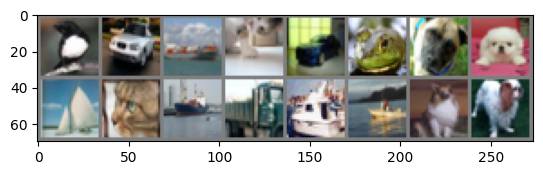

bird  car   ship  cat   car   frog  dog   dog   ship  cat   ship  truck ship  ship  dog   dog  


torch.Size([16, 3, 32, 32])

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

images.shape

In [97]:
images_d = images.to(device)
labels_d = labels.to(device)
model.en_gradCam()
out = model(images_d)
_, predicted = torch.max(out, 1)

grad_Activation_map = model.showGradCAM(criterion, out, labels_d)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

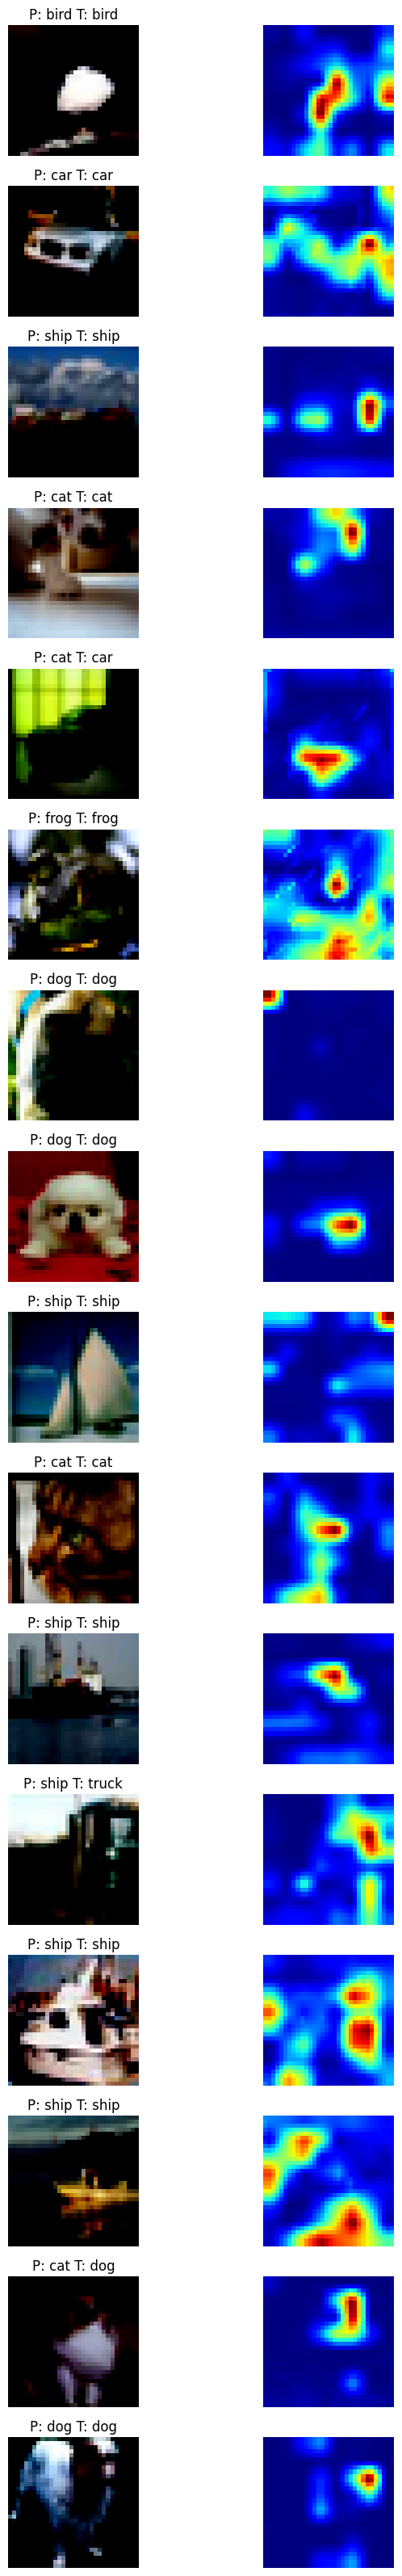

In [98]:

fig, axes = plt.subplots(batch_size, 2, figsize=(8, 2 * batch_size))

for i in range(batch_size):
    # Original Image
    ax = axes[i, 0]  # First column for the original image
    ax.imshow(np.transpose(images[i].cpu().detach().numpy(), (1, 2, 0)))
    ax.axis('off')
    ax.set_title(f"P: {classes[predicted[i]]} T: {classes[labels[i]]}")

    # Grad-CAM Activation Map
    ax = axes[i, 1]  # Second column for the Grad-CAM
    ax.imshow(grad_Activation_map[i].cpu().detach().numpy(), cmap='jet')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# images = images.to(device)
# labels = labels.to(device)
# out, feat_map = model(images)
# ans = 0
# cam_map = F.interpolate(torch.sum(model.linear[0].weight[labels].unsqueeze(-1).unsqueeze(-1) * feat_map, dim = 1).unsqueeze(1), size=(32, 32), mode = 'bilinear', align_corners=False)
# cam_map = cam_map - cam_map.min()  # Shift to 0
# cam_map = cam_map / cam_map.max()  # Scale to [0, 1]

# scaled_images = images
# scaled_images = scaled_images - scaled_images.min()  # Shift to 0
# scaled_images = scaled_images / scaled_images.max()  # Scale to [0, 1]
# scaled_images = scaled_images * 255.0          # Scale to [0, 255]

# cam_map = (cam_map * scaled_images).cpu().detach().numpy().astype(np.uint8)

# fig, axes = plt.subplots(1, 4, figsize=(10, 10))

# # Loop over the indices 1, 2, 3, 4 to display each

# _, predicted = torch.max(out, 1)


# for p in range(4):
#     ax = axes[p]  # Calculate subplot position
#     ax.imshow(np.transpose(cam_map[p], (1, 2, 0)))  # Display image
#     ax.set_title(f'Pred: {classes[predicted[p]]}, True: {classes[labels[p]]}')
#     ax.axis('off')  # Turn off axis for clarity

# plt.show()